In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

In [14]:
train = pd.read_csv('datasets/train.csv')
test = pd.read_csv('datasets/test.csv')

print(f"{'=' * 50}")
print(f"ДАННЫЕ ДО ОБРАБОТКИ:")
print(f"{'=' * 50}")
print(f"Тренировочные данные: {train.shape[0]} строк, {train.shape[1]} признаков")
print(f"Тестовые данные: {test.shape[0]} строк, {test.shape[1]} признаков")

train = train[~train['RiskScore'].isna()]
train = train[train['RiskScore'].between(0, 100)]

print(f"\n{'=' * 50}")
print(f"ДАННЫЕ ПОСЛЕ ОЧИСТКИ:")
print(f"{'=' * 50}")
print(f"Тренировочные данные: {train.shape[0]} строк, {train.shape[1]} признаков")
print(f"Удалено записей: {11017 - train.shape[0]}")

print(f"\n{'=' * 50}")
print(f"СТАТИСТИКА TARGET (RiskScore):")
print(f"{'=' * 50}")
stats = train['RiskScore'].describe()
print(f"Количество:    {stats['count']:.0f}")
print(f"Среднее:       {stats['mean']:.3f}")
print(f"Станд. откл.:  {stats['std']:.3f}")
print(f"Минимум:       {stats['min']:.3f}")
print(f"25-й перцентиль: {stats['25%']:.3f}")
print(f"Медиана:       {stats['50%']:.3f}")
print(f"75-й перцентиль: {stats['75%']:.3f}")
print(f"Максимум:      {stats['max']:.3f}")

ДАННЫЕ ДО ОБРАБОТКИ:
Тренировочные данные: 11017 строк, 35 признаков
Тестовые данные: 5000 строк, 35 признаков

ДАННЫЕ ПОСЛЕ ОЧИСТКИ:
Тренировочные данные: 10272 строк, 35 признаков
Удалено записей: 745

СТАТИСТИКА TARGET (RiskScore):
Количество:    10272
Среднее:       48.358
Станд. откл.:  17.241
Минимум:       14.841
25-й перцентиль: 32.723
Медиана:       44.196
75-й перцентиль: 65.124
Максимум:      97.597


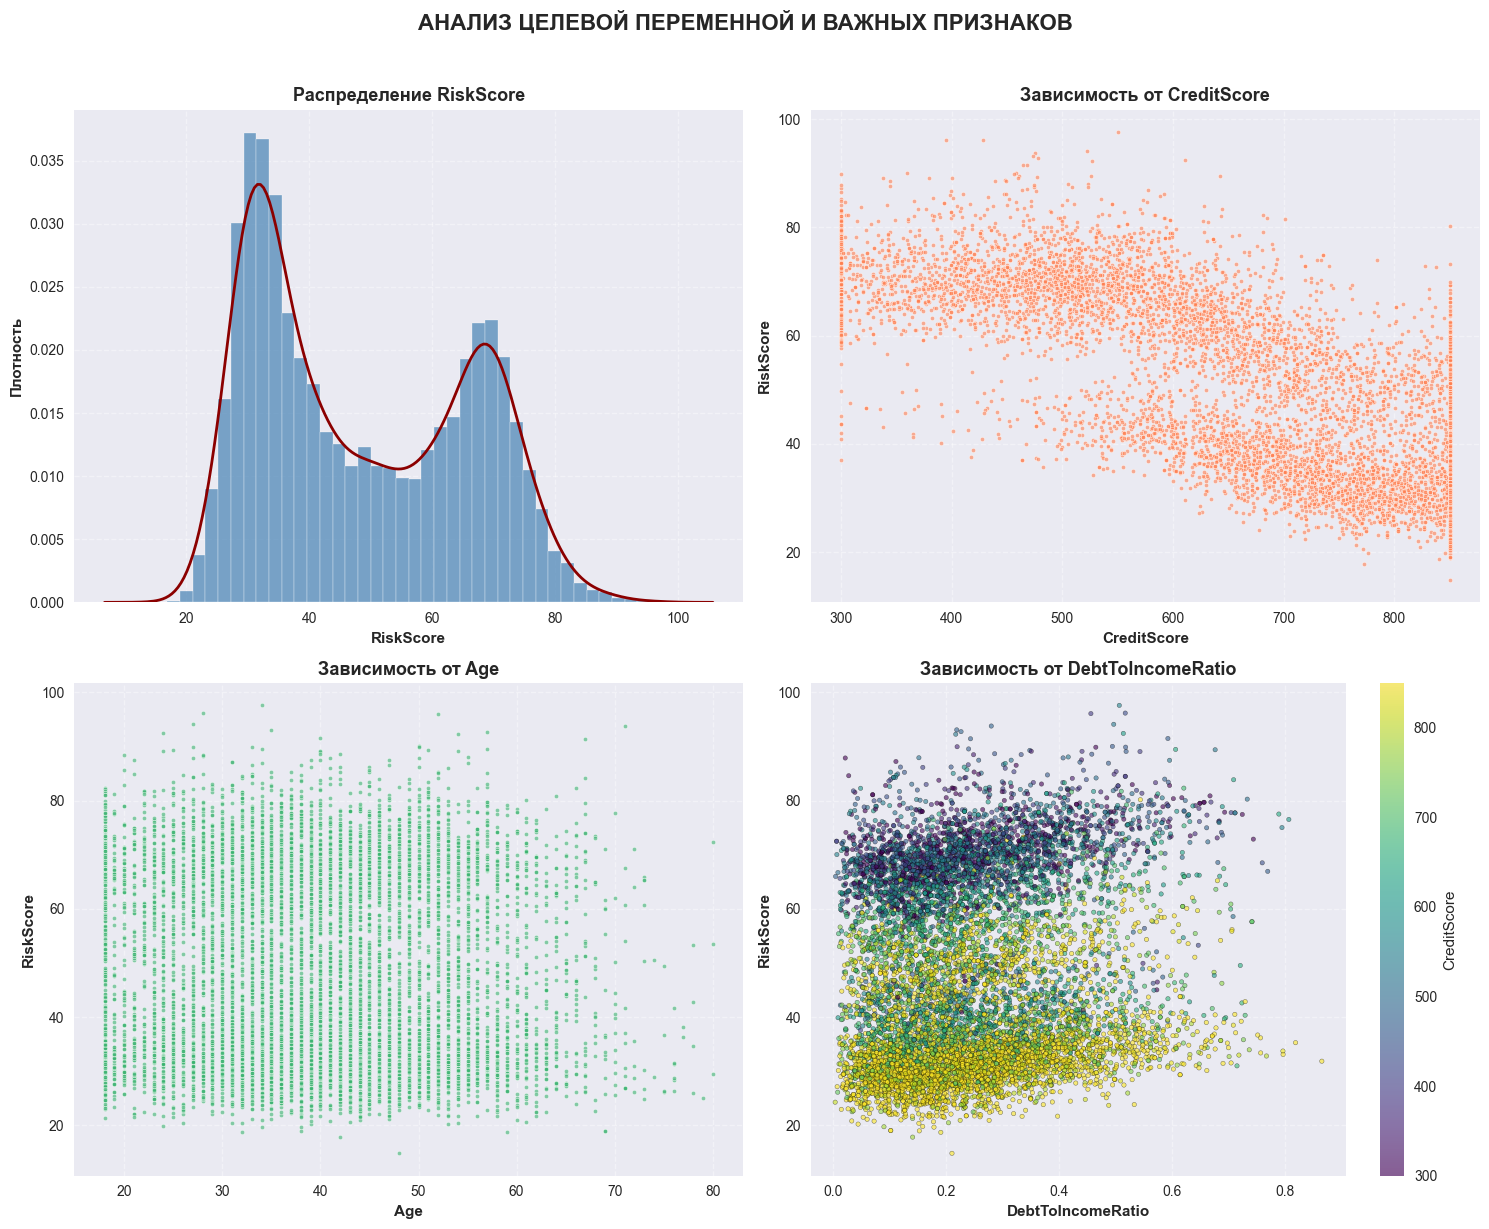

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ И ВАЖНЫХ ПРИЗНАКОВ',
             fontsize=16, fontweight='bold', y=1.02)

axes[0, 0].hist(train['RiskScore'], bins=40, color='steelblue',
                edgecolor='white', alpha=0.7, density=True)
sns.kdeplot(train['RiskScore'], ax=axes[0, 0], color='darkred', linewidth=2)
axes[0, 0].set_title('Распределение RiskScore', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('RiskScore', fontweight='bold')
axes[0, 0].set_ylabel('Плотность', fontweight='bold')
axes[0, 0].grid(True, alpha=0.4, linestyle='--')

axes[0, 1].scatter(train['CreditScore'], train['RiskScore'],
                   alpha=0.6, s=10, color='coral', edgecolor='white', linewidth=0.5)
axes[0, 1].set_title('Зависимость от CreditScore', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('CreditScore', fontweight='bold')
axes[0, 1].set_ylabel('RiskScore', fontweight='bold')
axes[0, 1].grid(True, alpha=0.4, linestyle='--')

axes[1, 0].scatter(train['Age'], train['RiskScore'],
                   alpha=0.6, s=10, color='mediumseagreen', edgecolor='white', linewidth=0.5)
axes[1, 0].set_title('Зависимость от Age', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Age', fontweight='bold')
axes[1, 0].set_ylabel('RiskScore', fontweight='bold')
axes[1, 0].grid(True, alpha=0.4, linestyle='--')

scatter = axes[1, 1].scatter(train['DebtToIncomeRatio'], train['RiskScore'],
                             alpha=0.6, s=10, c=train['CreditScore'],
                             cmap='viridis', edgecolor='black', linewidth=0.3)
axes[1, 1].set_title('Зависимость от DebtToIncomeRatio', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('DebtToIncomeRatio', fontweight='bold')
axes[1, 1].set_ylabel('RiskScore', fontweight='bold')
axes[1, 1].grid(True, alpha=0.4, linestyle='--')
plt.colorbar(scatter, ax=axes[1, 1], label='CreditScore')

plt.tight_layout()
plt.show()

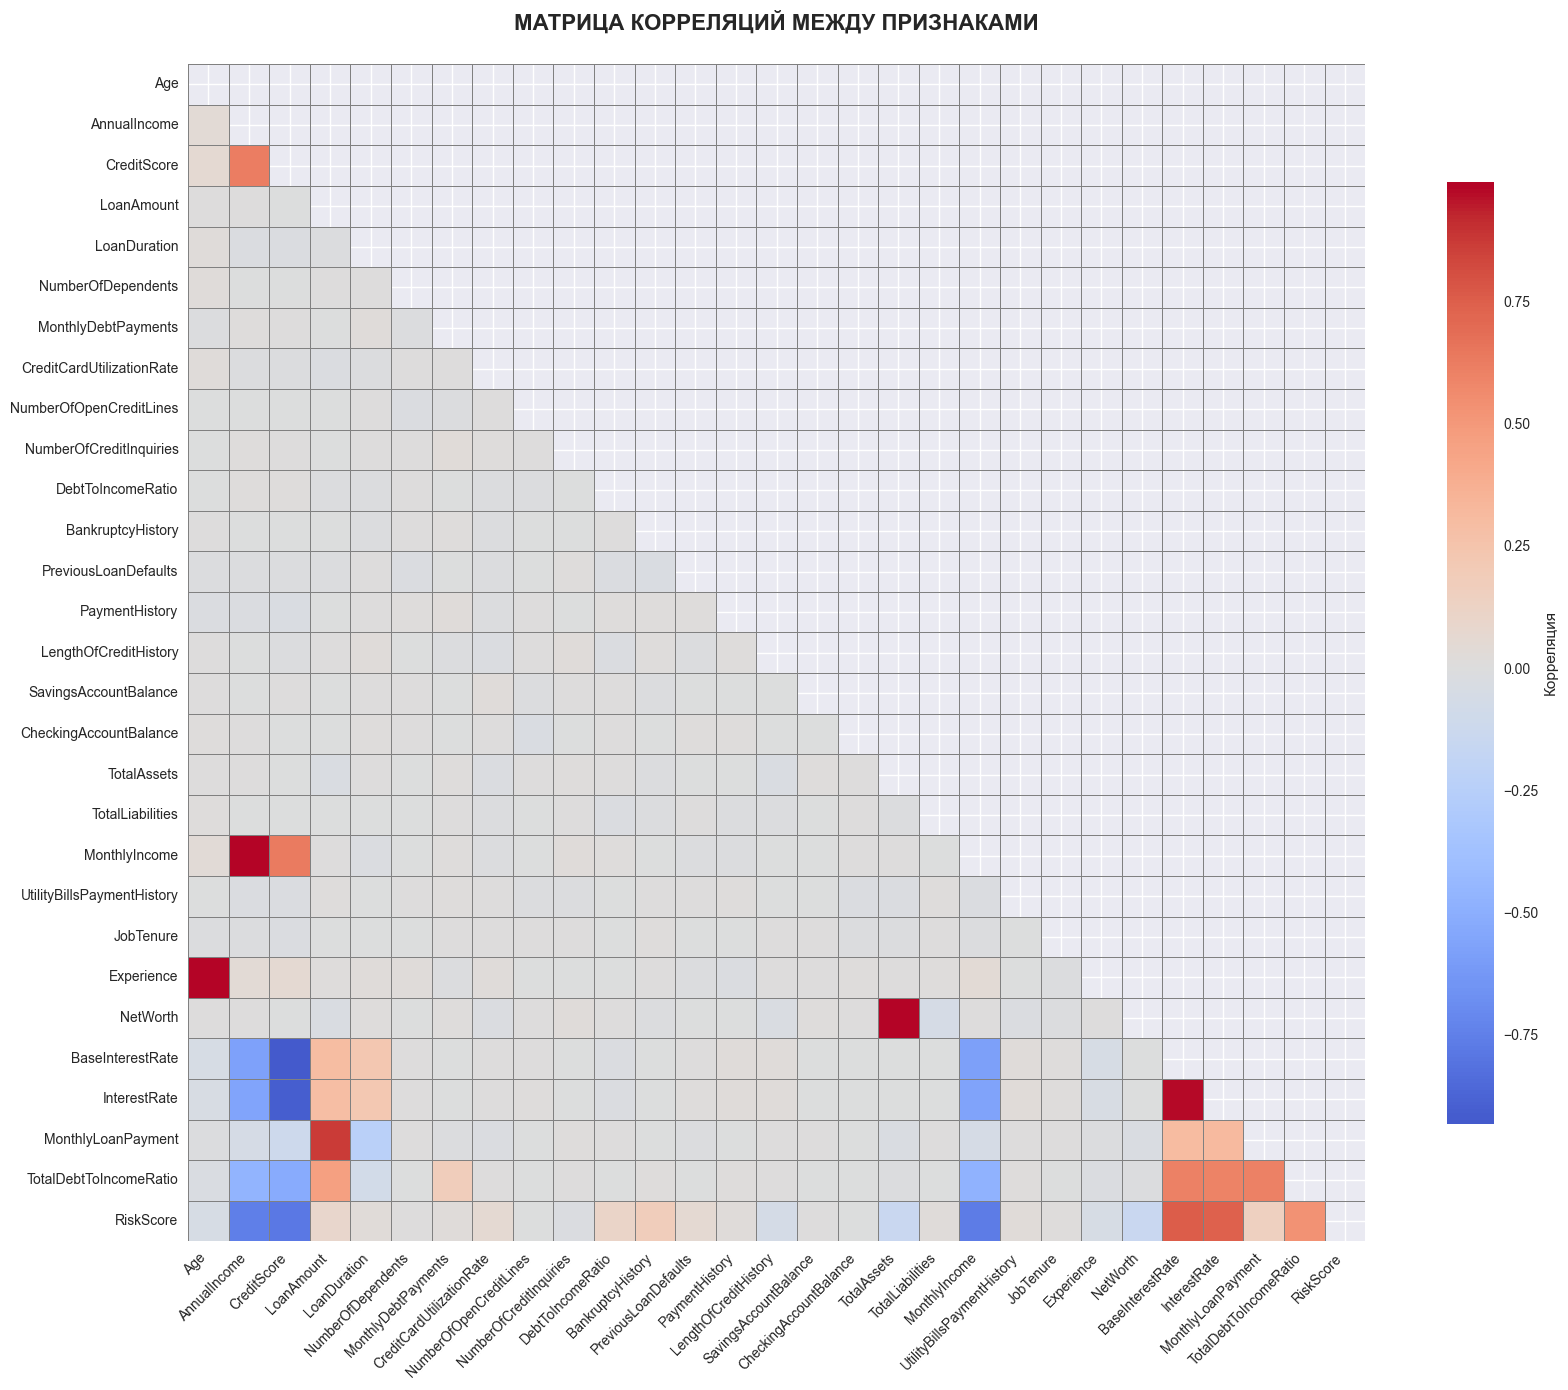


ТОП-10 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ С RISKSCORE:
 1. RiskScore                      🟢  1.0000 ████████████████████████████████████████
 2. BaseInterestRate               🟢  0.7587 ██████████████████████████████
 3. InterestRate                   🟢  0.7426 █████████████████████████████
 4. TotalDebtToIncomeRatio         🟢  0.5307 █████████████████████
 5. BankruptcyHistory              🟢  0.1776 ███████
 6. MonthlyLoanPayment             🟢  0.1508 ██████
 7. DebtToIncomeRatio              🟢  0.1109 ████
 8. LoanAmount                     🟢  0.0850 ███
 9. CreditCardUtilizationRate      🟢  0.0561 ██
10. PreviousLoanDefaults           🟢  0.0550 ██
11. LoanDuration                   🟢  0.0283 █


In [16]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train[numeric_cols].corr()

plt.figure(figsize=(18, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, cbar_kws={"shrink": 0.8, "label": "Корреляция"},
            linewidths=0.5, linecolor='gray')
plt.title('МАТРИЦА КОРРЕЛЯЦИЙ МЕЖДУ ПРИЗНАКАМИ',
          fontsize=16, fontweight='bold', pad=25)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\n{'=' * 50}")
print(f"ТОП-10 ПРИЗНАКОВ ПО КОРРЕЛЯЦИИ С RISKSCORE:")
print(f"{'=' * 50}")
risk_corr = correlation_matrix['RiskScore'].sort_values(ascending=False)
for idx, (feature, corr) in enumerate(risk_corr.head(11).items(), 1):
    bar = "█" * int(abs(corr) * 40)
    color = "🟢" if corr > 0 else "🔴"
    print(f"{idx:2}. {feature:30} {color} {corr:7.4f} {bar}")

In [17]:
def extract_date_features(df, col='ApplicationDate'):
    if col not in df.columns:
        return df

    dates = pd.to_datetime(df[col], errors='coerce')
    fallback_date = dates.mode()[0] if not dates.mode().empty else dates.min()
    dates = dates.fillna(fallback_date)

    new_features = {
        f'{col}_Year': dates.dt.year,
        f'{col}_Month': dates.dt.month,
        f'{col}_Quarter': dates.dt.quarter,
        f'{col}_Week': dates.dt.isocalendar().week.astype(float)
    }

    day_of_week = dates.dt.dayofweek
    angle = 2 * np.pi * day_of_week / 7.0
    new_features[f'{col}_DayOfWeek_Sin'] = np.sin(angle)
    new_features[f'{col}_DayOfWeek_Cos'] = np.cos(angle)

    return df.assign(**new_features).drop(columns=[col])

def add_binning_features(df):
    bins_config = {
        'CreditScore': [300, 580, 620, 660, 700, 740, 780, 820, 900],
        'AnnualIncome': [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf],
        'TotalDebtToIncomeRatio': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf],
        'InterestRate': [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf],
        'Age': [18, 30, 45, 60, np.inf],
        'LoanAmount': [0, 30000, 60000, 100000, np.inf],
    }

    binned_features = []

    for col, bins in bins_config.items():
        if col not in df.columns:
            continue

        binned = pd.cut(df[col], bins=bins, labels=False, duplicates='drop')
        dummies = pd.get_dummies(binned, prefix=f"Bin_{col}", drop_first=True, dtype=int)
        binned_features.append(dummies)

    if binned_features:
        return pd.concat([df] + binned_features, axis=1)
    return df

def preprocess_advanced(df, is_train=True, stats=None):
    EPS = 1e-5
    df = df.copy()
    quantiles = stats if stats is not None else {}

    if 'EducationLevel' in df.columns:
        education_mapping = {
            'High School': 1,
            'Associate': 2,
            'Bachelor': 3,
            'Master': 4,
            'Doctorate': 5
        }
        df['EducationLevel'] = df['EducationLevel'].map(education_mapping).fillna(0).astype(int)

    nominal_cols = ['HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus']
    cols_to_encode = [c for c in nominal_cols if c in df.columns]
    if cols_to_encode:
        df = pd.get_dummies(df, columns=cols_to_encode, drop_first=True, dtype=int)

    df = extract_date_features(df, 'ApplicationDate')
    df = df.fillna(df.mean(numeric_only=True))

    if 'InterestRate' in df.columns and 'BaseInterestRate' in df.columns:
        df['InterestRateSpread'] = df['InterestRate'] - df['BaseInterestRate']

    if 'AnnualIncome' in df.columns:
        if 'LoanAmount' in df.columns:
            df['LoanToIncome'] = df['LoanAmount'] / (df['AnnualIncome'] + EPS)
        if 'NetWorth' in df.columns:
            df['NetWorthToIncome'] = df['NetWorth'] / (df['AnnualIncome'] + EPS)
        if 'NumberOfDependents' in df.columns:
            df['IncomePerDependent'] = df['AnnualIncome'] / (df['NumberOfDependents'] + 1)
        if 'MonthlyIncome' in df.columns:
            df['IncomeDiscrepancy'] = df['AnnualIncome'] - (df['MonthlyIncome'] * 12.0)

    if all(col in df.columns for col in ['MonthlyIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments']):
        total_debt = df['MonthlyLoanPayment'] + df['MonthlyDebtPayments']
        disposable = df['MonthlyIncome'] - total_debt
        df['DebtServiceRatio'] = total_debt / (df['MonthlyIncome'] + EPS)
        df['DisposableIncome'] = disposable
        df['Stress_Loan_Payment_Ratio'] = df['MonthlyLoanPayment'] / disposable.replace(0, EPS)

    if 'TotalAssets' in df.columns and 'TotalLiabilities' in df.columns:
        df['LiabilityGap'] = df['TotalLiabilities'] - df['TotalAssets']
        df['AssetCoverage'] = df['TotalAssets'] / (df['TotalLiabilities'] + EPS)
        if 'NetWorth' in df.columns:
            df['NetWorthToLiabilities'] = df['NetWorth'] / (df['TotalLiabilities'] + EPS)

    if 'NumberOfOpenCreditLines' in df.columns:
        num_lines = df['NumberOfOpenCreditLines'] + 1
        if 'CreditCardUtilizationRate' in df.columns:
            df['UtilizationPerLine'] = df['CreditCardUtilizationRate'] / num_lines
        if 'NumberOfCreditInquiries' in df.columns:
            df['InquiryPerLine'] = df['NumberOfCreditInquiries'] / num_lines
        if 'TotalLiabilities' in df.columns:
            df['Avg_Debt_Per_Line'] = df['TotalLiabilities'] / num_lines

    if 'Age' in df.columns:
        if 'LengthOfCreditHistory' in df.columns:
            df['CreditHistoryToAge'] = df['LengthOfCreditHistory'] / (df['Age'] + EPS)
        if 'Experience' in df.columns:
            df['ExperienceToAge'] = df['Experience'] / (df['Age'] + EPS)

    cols_to_log = [
        'AnnualIncome', 'MonthlyLoanPayment', 'MonthlyDebtPayments',
        'TotalAssets', 'TotalLiabilities', 'LoanAmount', 'NetWorth',
        'IncomePerDependent', 'IncomeDiscrepancy', 'DisposableIncome',
        'LiabilityGap', 'Avg_Debt_Per_Line'
    ]

    for col in cols_to_log:
        if col in df.columns:
            df[col] = np.sign(df[col]) * np.log1p(np.abs(df[col]))

    df = add_binning_features(df)

    clip_cols = [
        'DebtServiceRatio', 'InquiryPerLine', 'Stress_Loan_Payment_Ratio',
        'AssetCoverage', 'NetWorthToLiabilities', 'UtilizationPerLine',
        'CreditHistoryToAge', 'LoanToIncome', 'DisposableIncome', 'LiabilityGap'
    ]

    if is_train:
        for col in clip_cols:
            if col in df.columns:
                quantiles[col] = df[col].quantile(0.65)

    for col in clip_cols:
        if col in df.columns and col in quantiles:
            threshold = quantiles[col]
            df[f'HighFlag_{col}'] = (df[col] > threshold).astype(int)
            df[col] = df[col].clip(upper=threshold)

    drop_cols = ['ID', 'MaritalStatus', 'BaseInterestRate']
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

    return df, quantiles

In [18]:
y = train['RiskScore']
X = train.drop(columns=['RiskScore'])
X_test_raw = test.copy()

print(f"\n{'=' * 50}")
print(f"ПРЕДОБРАБОТКА ДАННЫХ:")
print(f"{'=' * 50}")

start_time = datetime.now()
X, stats = preprocess_advanced(X, is_train=True)
X_test_raw, _ = preprocess_advanced(X_test_raw, is_train=False, stats=stats)
end_time = datetime.now()

train_cols = X.columns.tolist()
for col in train_cols:
    if col not in X_test_raw.columns:
        X_test_raw[col] = 0
X_test_raw = X_test_raw[train_cols]

print(f"Время обработки: {(end_time - start_time).total_seconds():.2f} сек")
print(f"\nРазмерности после предобработки:")
print(f"{'─' * 40}")
print(f"X_train: {X.shape[0]} × {X.shape[1]}")
print(f"X_test:  {X_test_raw.shape[0]} × {X_test_raw.shape[1]}")
print(f"Признаков добавлено: {X.shape[1] - 34}")


ПРЕДОБРАБОТКА ДАННЫХ:
Время обработки: 0.09 сек

Размерности после предобработки:
────────────────────────────────────────
X_train: 10272 × 92
X_test:  5000 × 92
Признаков добавлено: 58


In [19]:
class DataNormalizer:
    def __init__(self, method='zscore'):
        self.method = method
        self.params = {}

    def fit(self, X):
        if self.method == 'zscore':
            self.params['mean'] = np.mean(X, axis=0)
            self.params['std'] = np.std(X, axis=0)
            self.params['std'][self.params['std'] < 1e-9] = 1.0
        elif self.method == 'minmax':
            self.params['min'] = np.min(X, axis=0)
            self.params['max'] = np.max(X, axis=0)
            range_val = self.params['max'] - self.params['min']
            range_val[range_val < 1e-9] = 1.0
            self.params['range'] = range_val
        return self

    def transform(self, X):
        if self.method == 'zscore':
            return (X - self.params['mean']) / self.params['std']
        elif self.method == 'minmax':
            return (X - self.params['min']) / self.params['range']

    def fit_transform(self, X):
        return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
        if self.method == 'zscore':
            return X_scaled * self.params['std'] + self.params['mean']
        elif self.method == 'minmax':
            return X_scaled * self.params['range'] + self.params['min']

class MyLinearRegression:
    def __init__(self, method='analytic', alpha=0.01, learning_rate=0.01,
                 n_iterations=1000, batch_size=32, random_state=42):
        self.method = method
        self.alpha = alpha
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.batch_size = batch_size
        self.random_state = random_state
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X, dtype=float)
        y = np.array(y, dtype=float)
        n_samples, n_features = X.shape

        if self.method == 'analytic':
            X_b = np.c_[np.ones((n_samples, 1)), X]
            I = np.eye(n_features + 1)
            I[0, 0] = 0

            XtX = X_b.T @ X_b
            XtX_reg = XtX + (self.alpha * I)
            theta = np.linalg.pinv(XtX_reg) @ X_b.T @ y

            self.bias = theta[0]
            self.weights = theta[1:]

        elif self.method == 'gradient':
            self.weights = np.zeros(n_features)
            self.bias = 0

            for i in range(self.n_iterations):
                predictions = X @ self.weights + self.bias
                errors = predictions - y

                gradient_w = (1 / n_samples) * X.T @ errors + self.alpha * self.weights
                gradient_b = (1 / n_samples) * np.sum(errors)

                self.weights -= self.learning_rate * gradient_w
                self.bias -= self.learning_rate * gradient_b

        elif self.method == 'sgd':
            np.random.seed(self.random_state)
            self.weights = np.zeros(n_features)
            self.bias = 0

            for epoch in range(self.n_iterations):
                indices = np.random.permutation(n_samples)
                for start in range(0, n_samples, self.batch_size):
                    end = min(start + self.batch_size, n_samples)
                    X_batch = X[indices[start:end]]
                    y_batch = y[indices[start:end]]

                    predictions = X_batch @ self.weights + self.bias
                    errors = predictions - y_batch
                    bs = len(X_batch)

                    gradient_w = (1 / bs) * X_batch.T @ errors + self.alpha * self.weights
                    gradient_b = (1 / bs) * np.sum(errors)

                    self.weights -= self.learning_rate * gradient_w
                    self.bias -= self.learning_rate * gradient_b

        return self

    def predict(self, X):
        return np.array(X, dtype=float) @ self.weights + self.bias

def my_mse(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

def my_mae(y_true, y_pred):
    return np.mean(np.abs(np.array(y_true) - np.array(y_pred)))

def my_r2(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    if ss_tot < 1e-9:
        return 0.0
    return 1 - (ss_res / ss_tot)

def my_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    epsilon = 1e-8
    return 100 * np.mean(np.abs((y_true - y_pred) / (y_true + epsilon)))


СРАВНЕНИЕ МЕТОДОВ РЕГРЕССИИ:
Метод                     MSE        MAE        R²        
───────────────────────────────────────────────────────
Аналитический             29.1114    4.0143     0.9027    
Градиентный спуск         113.7974   9.1938     0.6195    
SGD                       116.5705   9.3220     0.6102    
───────────────────────────────────────────────────────
Sklearn                   29.1400    4.0163     0.9026    


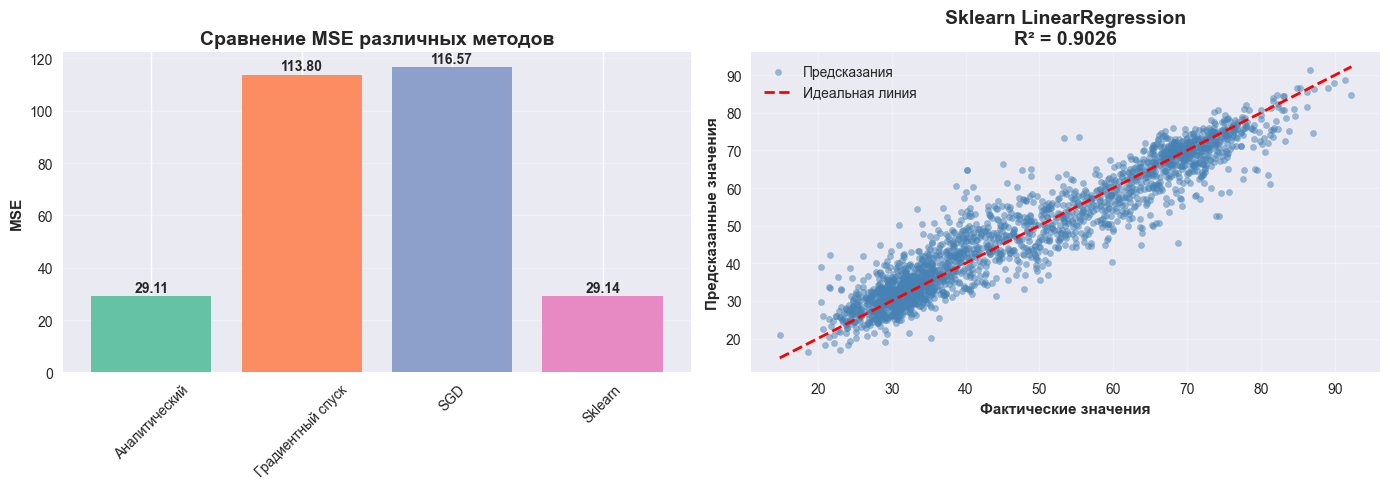

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X.values, y.values,
                                                  test_size=0.2, random_state=42)

normalizer = DataNormalizer('zscore')
X_train_norm = normalizer.fit_transform(X_train)
X_val_norm = normalizer.transform(X_val)

print(f"\n{'=' * 50}")
print(f"СРАВНЕНИЕ МЕТОДОВ РЕГРЕССИИ:")
print(f"{'=' * 50}")
print(f"{'Метод':<25} {'MSE':<10} {'MAE':<10} {'R²':<10}")
print(f"{'─' * 55}")

methods = [
    ('Аналитический', 'analytic', 10, {'alpha': 10}),
    ('Градиентный спуск', 'gradient', 10, {'alpha': 10, 'learning_rate': 0.01, 'n_iterations': 1000}),
    ('SGD', 'sgd', 10, {'alpha': 10, 'learning_rate': 0.01, 'n_iterations': 100, 'batch_size': 64}),
]

results = []
for name, method, _, params in methods:
    model = MyLinearRegression(method=method, **params)
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_val_norm)

    mse_val = mean_squared_error(y_val, y_pred)
    mae_val = mean_absolute_error(y_val, y_pred)
    r2_val = r2_score(y_val, y_pred)

    results.append((name, mse_val, mae_val, r2_val))
    print(f"{name:<25} {mse_val:<10.4f} {mae_val:<10.4f} {r2_val:<10.4f}")

sklearn_model = LinearRegression()
sklearn_model.fit(X_train_norm, y_train)
y_pred_sklearn = sklearn_model.predict(X_val_norm)
sklearn_mse = mean_squared_error(y_val, y_pred_sklearn)
sklearn_mae = mean_absolute_error(y_val, y_pred_sklearn)
sklearn_r2 = r2_score(y_val, y_pred_sklearn)

print(f"{'─' * 55}")
print(f"{'Sklearn':<25} {sklearn_mse:<10.4f} {sklearn_mae:<10.4f} {sklearn_r2:<10.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods_names = [r[0] for r in results] + ['Sklearn']
mse_values = [r[1] for r in results] + [sklearn_mse]

bars = axes[0].bar(methods_names, mse_values, color=sns.color_palette("Set2", len(methods_names)))
for i, (bar, val) in enumerate(zip(bars, mse_values)):
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
                 f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
axes[0].set_title('Сравнение MSE различных методов', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MSE', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

axes[1].scatter(y_val, y_pred_sklearn, alpha=0.5, s=20, color='steelblue', label='Предсказания')
axes[1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
             'r--', lw=2, label='Идеальная линия')
axes[1].set_xlabel('Фактические значения', fontweight='bold')
axes[1].set_ylabel('Предсказанные значения', fontweight='bold')
axes[1].set_title(f'Sklearn LinearRegression\nR² = {sklearn_r2:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
def k_fold_cv(X, y, model, k=5):
    n = len(X)
    fold_size = n // k
    indices = np.arange(n)
    np.random.shuffle(indices)
    scores = []

    for i in range(k):
        val_start = i * fold_size
        val_end = (i + 1) * fold_size if i < k - 1 else n
        val_idx = indices[val_start:val_end]
        train_idx = np.concatenate([indices[:val_start], indices[val_end:]])

        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[val_idx])
        scores.append(my_mse(y[val_idx], y_pred))

    return np.mean(scores), np.std(scores)

def loo_cv(X, y, model, max_samples=200):
    n = min(len(X), max_samples)
    scores = []

    for i in range(n):
        X_train = np.concatenate([X[:i], X[i + 1:n]])
        y_train = np.concatenate([y[:i], y[i + 1:n]])
        model.fit(X_train, y_train)
        y_pred = model.predict(X[i:i + 1])
        scores.append(my_mse(y[i:i + 1], y_pred))

    return np.mean(scores), np.std(scores)

print(f"\n{'=' * 50}")
print(f"КРОСС-ВАЛИДАЦИЯ:")
print(f"{'=' * 50}")

print("K-Fold кросс-валидация (k=5):")
model_cv = MyLinearRegression('analytic', alpha=10)
mean_mse_cv, std_mse = k_fold_cv(X_train_norm[:1000], y_train[:1000], model_cv, k=5)
print(f"  Средний MSE: {mean_mse_cv:.4f} ± {std_mse:.4f}")
print(f"  Диапазон: [{mean_mse_cv - std_mse:.4f}, {mean_mse_cv + std_mse:.4f}]")

print("\nLeave-One-Out кросс-валидация (200 сэмплов):")
model_loo = MyLinearRegression('analytic', alpha=10)
mean_mse_loo, std_mse_loo = loo_cv(X_train_norm[:200], y_train[:200], model_loo, max_samples=200)
print(f"  Средний MSE: {mean_mse_loo:.4f} ± {std_mse_loo:.4f}")
print(f"  Диапазон: [{mean_mse_loo - std_mse_loo:.4f}, {mean_mse_loo + std_mse_loo:.4f}]")


КРОСС-ВАЛИДАЦИЯ:
K-Fold кросс-валидация (k=5):
  Средний MSE: 33.0423 ± 5.1954
  Диапазон: [27.8469, 38.2377]

Leave-One-Out кросс-валидация (200 сэмплов):
  Средний MSE: 32.4961 ± 50.3721
  Диапазон: [-17.8760, 82.8682]


In [22]:
def create_smart_polynomials(X, poly_cols_indices):
    X_base = X.copy()
    X_poly = X[:, poly_cols_indices]

    squared = np.power(X_poly, 2)
    sqrt_transformed = np.sqrt(np.abs(X_poly) + 1e-3)

    from itertools import combinations
    max_cols = min(X_poly.shape[1], 20)
    interaction_pairs = combinations(range(max_cols), 2)
    interactions = np.column_stack([
        X_poly[:, i] * X_poly[:, j]
        for i, j in interaction_pairs
    ]) if max_cols > 1 else np.empty((X_poly.shape[0], 0))

    return np.hstack([X_base, squared, sqrt_transformed, interactions])

X_full = X.values
y_full = y.values

not_binary = [
    i for i, col in enumerate(train_cols)
    if not (col.startswith('Bin_') or col.startswith('HighFlag_') or
            '_Sin' in col or '_Cos' in col or col.startswith('Is_'))
]

corrs = []
for i in not_binary:
    c = np.corrcoef(X_full[:, i], y_full)[0, 1]
    if not np.isnan(c):
        corrs.append((i, abs(c)))

corrs.sort(key=lambda x: x[1], reverse=True)
top_poly_indices = [x[0] for x in corrs[:15]]

print(f"\n{'=' * 50}")
print(f"СОЗДАНИЕ ПОЛИНОМИАЛЬНЫХ ПРИЗНАКОВ:")
print(f"{'=' * 50}")
print(f"Топ-8 признаков для полиномов:")
for i, idx in enumerate(top_poly_indices[:8], 1):
    print(f"  {i:2}. {train_cols[idx]:30} (корр. = {corrs[i - 1][1]:.4f})")

X_full_poly = create_smart_polynomials(X_full, top_poly_indices)
X_test_poly = create_smart_polynomials(X_test_raw.values, top_poly_indices)

print(f"\nРазмерность признаков:")
print(f"  До:     {X_full.shape[1]}")
print(f"  После:  {X_full_poly.shape[1]}")
print(f"  Добавлено: {X_full_poly.shape[1] - X_full.shape[1]} признаков")


СОЗДАНИЕ ПОЛИНОМИАЛЬНЫХ ПРИЗНАКОВ:
Топ-8 признаков для полиномов:
   1. AnnualIncome                   (корр. = 0.8443)
   2. DebtServiceRatio               (корр. = 0.8074)
   3. MonthlyIncome                  (корр. = 0.7703)
   4. CreditScore                    (корр. = 0.7673)
   5. LoanToIncome                   (корр. = 0.7661)
   6. IncomePerDependent             (корр. = 0.7569)
   7. InterestRate                   (корр. = 0.7426)
   8. DisposableIncome               (корр. = 0.6386)

Размерность признаков:
  До:     92
  После:  227
  Добавлено: 135 признаков



ПОДБОР ПАРАМЕТРА РЕГУЛЯРИЗАЦИИ (alpha):
Alpha    MSE          MAE          R²          
────────────────────────────────────────────
0.01     24.5955      3.7148       0.9177      
0.05     24.6626      3.7206       0.9175      
0.10     24.6924      3.7235       0.9174      
0.50     24.7744      3.7288       0.9171      
1.00     24.8256      3.7323       0.9170      
5.00     24.9795      3.7432       0.9165      
10.00    25.0630      3.7488       0.9162      
20.00    25.1674      3.7560       0.9158      
50.00    25.3457      3.7718       0.9152      
────────────────────────────────────────────
Лучший Alpha: 0.01
Лучший MSE:   24.5955


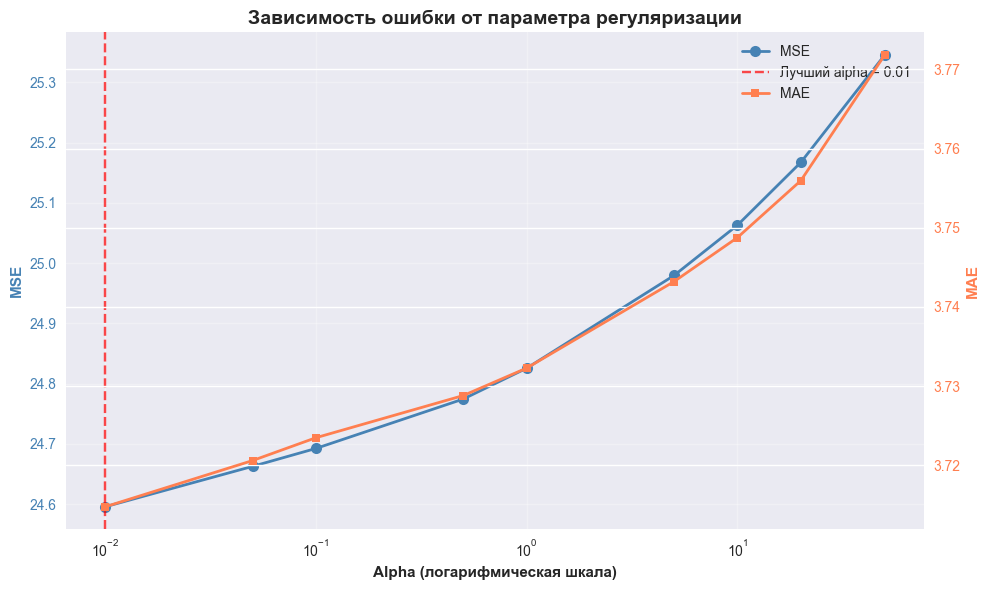

In [23]:
np.random.seed(42)
indices = np.random.permutation(len(X_full_poly))
split_idx = int(len(X_full_poly) * 0.8)

X_tr, X_vl = X_full_poly[indices[:split_idx]], X_full_poly[indices[split_idx:]]
y_tr, y_vl = y_full[indices[:split_idx]], y_full[indices[split_idx:]]

scaler_x = DataNormalizer('zscore')
X_tr_scaled = scaler_x.fit_transform(X_tr)
X_vl_scaled = scaler_x.transform(X_vl)
X_test_scaled = scaler_x.transform(X_test_poly)

scaler_y = DataNormalizer('zscore')
y_tr_scaled = scaler_y.fit_transform(y_tr.reshape(-1, 1)).ravel()

print(f"\n{'=' * 50}")
print(f"ПОДБОР ПАРАМЕТРА РЕГУЛЯРИЗАЦИИ (alpha):")
print(f"{'=' * 50}")
print(f"{'Alpha':<8} {'MSE':<12} {'MAE':<12} {'R²':<12}")
print(f"{'─' * 44}")

alphas = [0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 50.0]
best_mse = float('inf')
best_alpha = 0.01
best_model = None
alpha_results = []

for alpha in alphas:
    model = MyLinearRegression('analytic', alpha=alpha)
    model.fit(X_tr_scaled, y_tr_scaled)

    p_vl_scaled = model.predict(X_vl_scaled)
    p_vl = scaler_y.inverse_transform(p_vl_scaled.reshape(-1, 1)).ravel()
    p_vl = np.clip(p_vl, 0, 100)

    mse = my_mse(y_vl, p_vl)
    mae = my_mae(y_vl, p_vl)
    r2 = my_r2(y_vl, p_vl)

    alpha_results.append((alpha, mse, mae, r2))
    print(f"{alpha:<8.2f} {mse:<12.4f} {mae:<12.4f} {r2:<12.4f}")

    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha
        best_model = model

print(f"{'─' * 44}")
print(f"Лучший Alpha: {best_alpha:.2f}")
print(f"Лучший MSE:   {best_mse:.4f}")

fig, ax1 = plt.subplots(figsize=(10, 6))

alphas_vals = [r[0] for r in alpha_results]
mse_vals = [r[1] for r in alpha_results]
mae_vals = [r[2] for r in alpha_results]

ax1.semilogx(alphas_vals, mse_vals, 'o-', linewidth=2, markersize=8,
             color='steelblue', label='MSE')
ax1.axvline(x=best_alpha, color='red', linestyle='--', alpha=0.7,
            label=f'Лучший alpha = {best_alpha}')
ax1.set_xlabel('Alpha (логарифмическая шкала)', fontweight='bold')
ax1.set_ylabel('MSE', fontweight='bold', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')
ax1.grid(True, alpha=0.3)
ax1.set_title('Зависимость ошибки от параметра регуляризации',
              fontsize=14, fontweight='bold')

ax2 = ax1.twinx()
ax2.semilogx(alphas_vals, mae_vals, 's-', linewidth=2, markersize=6,
             color='coral', label='MAE')
ax2.set_ylabel('MAE', fontweight='bold', color='coral')
ax2.tick_params(axis='y', labelcolor='coral')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

In [26]:
pred_test_scaled = best_model.predict(X_test_scaled)
pred_test = scaler_y.inverse_transform(pred_test_scaled.reshape(-1, 1)).ravel()
pred_test = np.clip(pred_test, 0, 100)

test_ids = test['ID'] if 'ID' in test.columns else pd.Series(range(len(test)))
submission = pd.DataFrame({
    'ID': test_ids,
    'RiskScore': pred_test
})

submission.to_csv('submission.csv', index=False)

print(f"\n{'=' * 50}")
print(f"РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЙ:")
print(f"{'=' * 50}")
print(f"Статистика предсказаний на тестовой выборке:")
print(f"{'─' * 40}")
print(f"Минимум:    {pred_test.min():.2f}")
print(f"Максимум:   {pred_test.max():.2f}")
print(f"Среднее:    {pred_test.mean():.2f}")
print(f"Медиана:    {np.median(pred_test):.2f}")
print(f"Станд. откл: {pred_test.std():.2f}")
print(f"Q1:         {np.percentile(pred_test, 25):.2f}")
print(f"Q3:         {np.percentile(pred_test, 75):.2f}")

print(f"\nПервые 15 предсказаний:")
print(f"{'─' * 40}")
print(f"{'ID':<6} {'RiskScore':<12} {'Percentile':<12}")
print(f"{'─' * 40}")

for i in range(min(15, len(submission))):
    score = submission.iloc[i]['RiskScore']
    percentile = np.sum(pred_test <= score) / len(pred_test) * 100
    print(f"{submission.iloc[i]['ID']:<6} {score:<12.2f} {percentile:<12.1f}%")

print(f"\n{'=' * 50}")
print(f"ФАЙЛ submission.csv УСПЕШНО СОХРАНЕН!")
print(f"{'=' * 50}")


РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЙ:
Статистика предсказаний на тестовой выборке:
────────────────────────────────────────
Минимум:    14.73
Максимум:   94.77
Среднее:    48.17
Медиана:    44.55
Станд. откл: 16.66
Q1:         33.11
Q3:         64.37

Первые 15 предсказаний:
────────────────────────────────────────
ID     RiskScore    Percentile  
────────────────────────────────────────
0.0    34.31        29.1        %
1.0    52.81        61.2        %
2.0    28.32        7.6         %
3.0    35.56        32.8        %
4.0    33.94        28.0        %
5.0    71.39        89.5        %
6.0    31.58        19.1        %
7.0    32.33        22.2        %
8.0    37.72        38.5        %
9.0    66.39        78.1        %
10.0   32.83        24.1        %
11.0   31.12        17.2        %
12.0   66.66        78.5        %
13.0   37.98        39.1        %
14.0   32.86        24.2        %

ФАЙЛ submission.csv УСПЕШНО СОХРАНЕН!
